In [75]:
#Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import operator
from sqlalchemy import create_engine
import psycopg2
import plotly.express as px
import warnings
#import pygraphviz
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
import datatable as dt
import sidetable as stb

### Summary
* Read dependency edgelist -> Create Graph -> Calc Centrality Measures
* Read cost commits table -> Join with centrality measures -> Create pkg_cost_woth_dep metric
* Read downloads -> Join with cost and centrality measures to create metric table
* Create resuse of dependencies -> join with metrics table
* Explore correlations
* Explore other relationships

### Read Dependency Edgelist

* Original edgelist - 554604 - github hosted
* After removing None(such as numpy which do not have dependencies) we have 409385 rows
* 89127 unique nodes

In [76]:
#read the data from dependency edgelist
url = '/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/dependency_edgelist_03072022.csv'
#remove the unnanmed column created by csv
dep_df = pd.read_csv(url).drop(columns=['Unnamed: 0'])
#convert all the text to lower case
dep_df = dep_df.apply(lambda x: x.astype(str).str.lower())
#drop duplicate rows because version is not accounted for, there are many duplicate rows with same name
dep_df = dep_df.drop_duplicates()
#check final shape
dep_df.shape

(554604, 2)

In [77]:
#remove rows with no dependencies
dep_df = dep_df[dep_df.dependency_name!='none']

In [78]:
dep_df.shape

(409385, 2)

In [79]:
dep_df[dep_df.name=='numpy']

,name,dependency_name


In [80]:
dep_df.name.nunique()

75000

### Create Graph

In [81]:
#create Graph as directed graph
G = nx.from_pandas_edgelist(dep_df, 'name', 'dependency_name',create_using=nx.DiGraph() )
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 89127
Number of edges: 409385
Average in degree:   4.5933
Average out degree:   4.5933


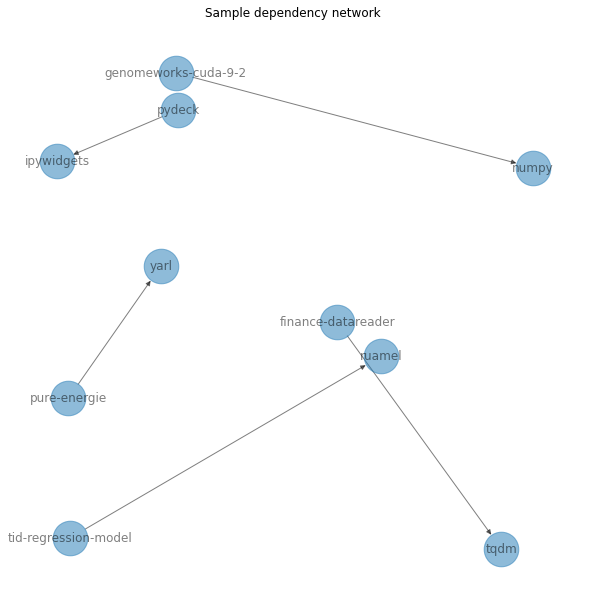

In [82]:
  # Seed layout for reproducibility
plt.figure(figsize=(8,8))
#https://www.python-graph-gallery.com/323-directed-or-undirected-network
# Build your graph. Note that we use the DiGraph function to create the graph!
G_test=nx.from_pandas_edgelist(dep_df.sample(5), 'name', 'dependency_name', create_using=nx.DiGraph() )
# Make the graph
nx.draw_random(G_test, with_labels=True, node_size=1200, alpha=0.5,font_size=12, font_color="black")
plt.title("Sample dependency network ")
plt.savefig('take1_np_sample_dep.png',bbox_inches='tight')
plt.show()

### NW Analysis - Centrality Measures

In [83]:
# %%
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/

#using networkx package to determine degree centrality and saving in a dataframe
deg_centrality = nx.degree_centrality(G)
s  = pd.Series(deg_centrality,index=deg_centrality.keys())
deg_centrality_df = pd.DataFrame(s)
deg_centrality_df = deg_centrality_df.reset_index()
deg_centrality_df.columns = ['node','deg_centrality']
deg_centrality_df = deg_centrality_df.set_index('node')

# Appending In/Out Degree Centrality to dataframe
in_deg_centrality = nx.in_degree_centrality(G)
in_deg_centrality_s = pd.DataFrame(pd.Series(in_deg_centrality,index=in_deg_centrality.keys()))
deg_centrality_df['in_deg_centrality'] = in_deg_centrality_s
out_deg_centrality = nx.out_degree_centrality(G)
out_deg_centrality_s = pd.DataFrame(pd.Series(out_deg_centrality,index=out_deg_centrality.keys()))
deg_centrality_df['out_deg_centrality'] = out_deg_centrality_s

# Appending Eigen Vector Centrality to the dataframe
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html
# * Centrality for a node computed based on the centrality of its neighbors 
# * Nodes with higher values depend on fewer packages 
# * Eigenvector for node ⅈ is Ax=x where A is the adjacency matrix of graph G with eigenvalue 
# * Significant or influential nodes enable the development of the packages dependent on them reducing overall development costs and time to complete development. 

eigen_vec_centrality = nx.eigenvector_centrality(G,max_iter=10000)
eigen_vec_centrality_s = pd.DataFrame(pd.Series(eigen_vec_centrality,index=eigen_vec_centrality.keys()))
deg_centrality_df['eigen_vec_centrality'] = eigen_vec_centrality_s
deg_centrality_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89127 entries, vcert to odoo10-addon-purchase-stock-picking-return-invoicing
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   deg_centrality        89127 non-null  float64
 1   in_deg_centrality     89127 non-null  float64
 2   out_deg_centrality    89127 non-null  float64
 3   eigen_vec_centrality  89127 non-null  float64
dtypes: float64(4)
memory usage: 3.4+ MB


<AxesSubplot:>

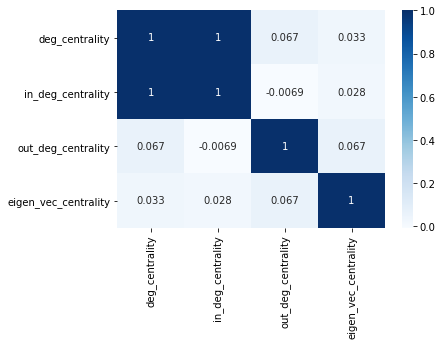

In [84]:
#exploration of correlation between centrality measures
sns.heatmap(deg_centrality_df.corr(),annot=True,cmap='Blues')

In [85]:
deg_centrality_df.shape

(89127, 4)

In [87]:
deg_centrality_df_no_out = deg_centrality_df.copy()

### Read the cost data and create cost metrics
* pkg_cost from cocomo calcualtion
* pkg_cost_with_dep = pkg_cost + dep_cost

In [88]:
#making conenction to postgresSQL DB
pgpassword = os.getenv('password')
pguser = os.getenv('user')
host =  'postgis1-s.bii.virginia.edu'
database = 'sdad'
#port = 

#trying connection
dbserver_p = psycopg2.connect(
    user=pguser, 
    password=pgpassword, 
    host=host,
    database=database 
)

#dbserver_p.autocommit = True
cursor_p = dbserver_p.cursor()
engine_p = create_engine("postgresql+psycopg2://{user}:{pw}@{host}/{db}"
                       .format(user=pguser, pw=pgpassword, host=host, db=database))

In [89]:
# Take in a PostgreSQL engine and query and return dataframe
def load_db_table(query, eng):
    '''
    Function which will use connection engine with pd.read_sql_query
    '''
    data = pd.read_sql_query(query, con=eng)
    return data

def load_tbl_cur(query, cursor):
    '''
    Function which will use cursor and fetch all the rows
    from result of sql query and convert to pandas dataframe
    '''
    cursor.execute(query)
    df = cursor.fetchall()
    colnames = [x[0] for x in cursor.description]
    return pd.DataFrame(df, columns=colnames)

In [90]:
# read the cost table joined with our cleaner slugs and create cost by repo
myquery = """
        select *
        from gh.pypi_cost_by_repo_clean_lower_04022022_2
"""
pkg_cost_tbl_1 = load_db_table(myquery,engine_p)
pkg_cost_tbl_1.sample(15)

,slug_meta,slug,commits,additions,deletions,sum_adds_dels,net_adds_dels
32391,kimnorgaard/zenhest,KimNorgaard/ZenHest,16,1552,1238,2790,314
36153,maciejkula/glove-python,maciejkula/glove-python,34,2141,329,2470,1812
38321,merck/deepbgc,Merck/deepbgc,61,2928,396,3324,2532
59279,stefanbraun-private/visitoolkit_connector,stefanbraun-private/visitoolkit_connector,6,5201,1938,7139,3263
47641,palankai/pyrs-schema,palankai/pyrs-schema,90,7595,2895,10490,4700
21228,frascoweb/frasco-eu-vat,frascoweb/frasco-eu-vat,7,355,31,386,324
13131,crispycret/crispys_webkit,crispycret/crispys_webkit,21,1028,263,1291,765
60085,svenkreiss/databench,svenkreiss/databench,1099,87222,69712,156934,17510
12643,conanfanli/command-streamer,conanfanli/command-streamer,19,397,42,439,355
66056,waydotnet/urllib_s3,WaYdotNET/urllib_s3,29,388,74,462,314


In [91]:
pkg_cost_tbl_1.shape

(68992, 7)

In [92]:
# read the cost table joined with our cleaner slugs and create cost by repo
myquery = """
        select *
        from gh.pypi_meta_slug_cleaner_04022022
"""
df_for_name = load_db_table(myquery,engine_p)
df_for_name.sample(15)

,name,slug
116337,django-lightpdf,claudiutopriceanu/django-lightpdf
40024,nero,mixmastamyk/nero
55820,flat-file-gdpr-anonymiser,yforecasting/flat_file_gdpr_anonymiser
58962,launchpad-py,fmmt666/launchpad.py
115764,linear-congruential-generator,onuratakan/linear_congruential_generator
34172,sql-orm,shubhamdipt/sql-orm
136331,textblob-ar-mk,adhaamehab/textblob-ar
152225,sqlacfg,mbr/sqlacfg
98463,pictil,chrisoftheboyerclan/pictil
14648,i2t2,ucsf-intelligent-imaging/i2t2/tree/master


In [93]:
pkg_cost_tbl = pkg_cost_tbl_1.merge(df_for_name,left_on='slug_meta',right_on='slug',how='left').drop_duplicates('slug_meta')

In [94]:
#COST BASED ON Additions - Deletions (given by Brandon based on COCOMO)
pkg_cost_tbl['pkg_cost'] = (22094.19 * 2.5 * (2.4 * (pkg_cost_tbl['sum_adds_dels']/1000)**1.05)**0.38).round(2)

In [95]:
#change all package names to lower case and check info to make sure we have correct dtypes
#pkg_cost_tbl.pkg_name = pkg_cost_tbl.name.apply(lambda x: x.lower())
pkg_cost_tbl = pkg_cost_tbl.drop(columns=['slug_x','slug_y'])

pkg_cost_tbl

,slug_meta,commits,additions,deletions,sum_adds_dels,net_adds_dels,name,pkg_cost
0,007gzs/avatars,11,4358,132,4490,4226,avatars,140263.49
1,007gzs/dingtalk-sdk,120,177884,60846,238730,117038,dingtalk-sdk,684673.09
2,007gzs/django_restframework_apiview,167,9182,1657,10839,7525,django-restframework-apiview,199369.66
6,007gzs/lbs,7,3254,65,3319,3189,lbs,124331.24
7,007gzs/pyallinpay,22,3069,61,3130,3008,pyallinpay,121456.44
...,...,...,...,...,...,...,...,...
559747,zzzap/celery-sprout,7,247,7,254,240,celery-sprout,44588.93
559748,zzzbit/zzz-utils,1,201,0,201,201,zzzutils,40613.80
559749,zzzirk/codewords,41,1282,115,1397,1167,codewords,88030.21
559750,zzzsochi/includer,9,385,7,392,378,includer,53017.53


In [96]:
df_for_name[df_for_name.name=='lights']

,name,slug
10429,lights,spyoungtech/lights


In [97]:
pkg_cost_tbl_1[pkg_cost_tbl_1['slug_meta'].str.contains('spyoungtech/lights')]

,slug_meta,slug,commits,additions,deletions,sum_adds_dels,net_adds_dels
58939,spyoungtech/lights,spyoungtech/lights,1,2,0,2,2


In [98]:
#groupby the pkg table by pkg name and cost to bring it to the form we want and remove columns we don't need
pkg_cost_tbl = pd.DataFrame(pkg_cost_tbl.groupby('name')['pkg_cost'].sum())
pkg_cost_tbl = pkg_cost_tbl.reset_index()
pkg_cost_tbl = pkg_cost_tbl.sort_values(by='pkg_cost',ascending=False)
pkg_cost_tbl

,name,pkg_cost
40878,pycmssw,8177945.69
3846,bashplotlib,8132726.37
26614,jams,8013475.62
18677,fairness-cscheid,7437293.33
35697,openquake.engine,7193201.29
...,...,...
33634,nci-config-loader,6453.71
468,adafruit-pca9685,6453.71
29263,lights,6453.71
12937,django-ib-basket,6453.71


In [99]:
'''Add dependency cost calcualted by BFS s othat we are calc cost of all
dependencies and their dependencies and not just immdieate neighbors'''

dep_cost_bfs = pd.read_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/dep_df_no_dup_dep_cost_bfs.csv')\
.drop(columns=['Unnamed: 0'])
dep_cost_bfs

,name,dep_cost
0,vcert,16471399.63
1,fast-histogram,15427210.88
2,drover,4769496.23
3,pyqstrat,1266268.36
4,nemea-pycommon,348082.46
...,...,...
74995,odoo10-addon-stock-inventory-discrepancy,0.00
74996,simple-zpl2,0.00
74997,plot-dots,0.00
74998,https.server,15427210.88


In [100]:
dep_df[dep_df.name=='pytest']

,name,dependency_name


In [101]:
dep_cost_bfs.sort_values(by='dep_cost',ascending=False)

,name,dep_cost
36965,ai-python,70957589.79
28836,ersilia,68634084.09
66888,bento2seldon4recsys,68442561.21
12879,bento2seldon,68442561.21
5832,bentoml,67971726.33
...,...,...
53009,oy-libs-sqlalchemy-mptt,0.00
53007,djangosecretkey,0.00
53006,headnode-notifier,0.00
7683,dhcpkit,0.00


In [102]:
pkg_cost_tbl_with_dep_cost = pkg_cost_tbl.merge(dep_cost_bfs,on='name',how='left')

In [103]:
pkg_cost_tbl_with_dep_cost.dep_cost = pkg_cost_tbl_with_dep_cost.dep_cost.fillna(0)

In [104]:
no_dep_cost = pkg_cost_tbl_with_dep_cost[pkg_cost_tbl_with_dep_cost.dep_cost==0].name.to_list()

In [105]:
pkg_cost_tbl_with_dep_cost.shape

(61600, 3)

In [106]:
pkg_cost_tbl_with_dep_cost

,name,pkg_cost,dep_cost
0,pycmssw,8177945.69,0.00
1,bashplotlib,8132726.37,0.00
2,jams,8013475.62,0.00
3,fairness-cscheid,7437293.33,10553227.49
4,openquake.engine,7193201.29,17966160.64
...,...,...,...
61595,nci-config-loader,6453.71,0.00
61596,adafruit-pca9685,6453.71,0.00
61597,lights,6453.71,0.00
61598,django-ib-basket,6453.71,97268.79


In [107]:
#confirmed that all packages with no dfep cost really do not have dependencies
dep_df[dep_df.name.isin(no_dep_cost)].name.nunique()

8643

In [108]:
#add pkg_cost + dep_cost to get new_cost
pkg_cost_tbl_with_dep_cost

,name,pkg_cost,dep_cost
0,pycmssw,8177945.69,0.00
1,bashplotlib,8132726.37,0.00
2,jams,8013475.62,0.00
3,fairness-cscheid,7437293.33,10553227.49
4,openquake.engine,7193201.29,17966160.64
...,...,...,...
61595,nci-config-loader,6453.71,0.00
61596,adafruit-pca9685,6453.71,0.00
61597,lights,6453.71,0.00
61598,django-ib-basket,6453.71,97268.79


#### Join num_downloads to the metrics table

* read downloads data
* left join with rest of the metrics

In [109]:
#read the downloads data csv using datatable instead of pandas because the files is huge
dwndf = dt.fread("/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_downloads_365DAY_01012020.csv")

In [110]:
#convert the datatabel to pandas dataframe
dwnld_df = dwndf.to_pandas()
#drop the C0 column created by csv
dwnld_df = dwnld_df.drop(columns=['C0'])
#groupby downloads just by package and downloads and get rid of other columns
dwnld_gb = dwnld_df[['name','num_downloads']].groupby('name').sum()
#reset index and rename name column to pkg_name for consistency
dwnld_gb = dwnld_gb.reset_index()
dwnld_gb.columns=['pkg_name','num_dwnloads']

In [111]:
dwnld_gb

,pkg_name,num_dwnloads
0,0,11187
1,0-0-1,5541
2,0-1,2
3,0-core-client,23969
4,0-orchestrator,34232
...,...,...
288658,zzzeeksphinx,7386
288659,zzzfs,1521
288660,zzzutils,2048
288661,zzzz,1549


In [112]:
#dwnld_gb.nlargest(100, 'num_dwnloads').num_dwnloads.cumsum()
dwnld_gb=dwnld_gb.sort_values(by='num_dwnloads',ascending=False)
dwnld_gb['cum_percent'] = 100*(dwnld_gb.num_dwnloads.cumsum() / dwnld_gb.num_dwnloads.sum())
dwnld_gb.sort_values(by='num_dwnloads',ascending=False)

,pkg_name,num_dwnloads,cum_percent
271268,urllib3,1307838418,1.925612
239920,six,1148580936,3.616740
24946,botocore,1007087949,5.099539
223683,requests,952566053,6.502061
235989,setuptools,950167049,7.901052
...,...,...,...
11327,argparse-better,1,99.999998
140316,meinebopy,1,99.999998
24742,boringstuff909,1,99.999998
86087,filepursuer,1,99.999998


In [113]:
top_95_pct = dwnld_gb[0:3249]

In [114]:
top_50_pct = dwnld_gb[0:97]

In [115]:
top_5_dwn = dwnld_gb.sort_values(by='num_dwnloads',ascending=False).head()

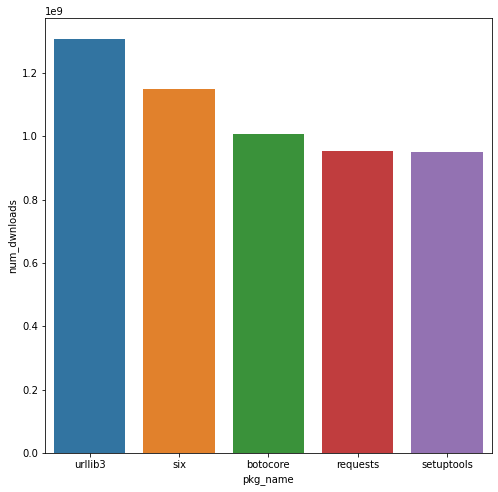

In [116]:
plt.figure(figsize=(8,8))
sns.barplot(data=top_5_dwn,x='pkg_name',y='num_dwnloads',orient='v');
plt.savefig('top_5_dwn.png',bbox_inches='tight')

In [117]:
metrics_df = pkg_cost_tbl_with_dep_cost.merge(dwnld_gb,how='left',left_on='name',right_on='pkg_name')
metrics_df.sample(10)

,name,pkg_cost,dep_cost,pkg_name,num_dwnloads,cum_percent
48320,pytest-bench,74677.35,0.00,pytest-bench,8530.0,99.179620
25540,django-exo-role,141636.90,97268.79,django-exo-role,11227.0,98.995908
51158,tiffstack2avi,68020.26,0.00,tiffstack2avi,2614.0,99.748278
18797,cmddocs,182300.56,0.00,cmddocs,15237.0,98.782314
3522,djangocodemirror,632655.12,0.00,djangocodemirror,28271.0,98.329288
58855,datasette-doublemetaphone,47139.62,19709631.65,datasette-doublemetaphone,827.0,99.965178
37666,tenet,99939.13,0.00,tenet,4469.0,99.538379
35677,dataexplore_plot,105364.36,0.00,NaN,NaN,NaN
1321,fcgdctools,1161398.65,0.00,fcgdctools,7511.0,99.258501
55427,mr4mp,57479.58,0.00,mr4mp,6063.0,99.381182


In [118]:
metrics_df.num_dwnloads = metrics_df.num_dwnloads.fillna(0)

In [119]:
metrics_df[metrics_df.num_dwnloads==0]

,name,pkg_cost,dep_cost,pkg_name,num_dwnloads,cum_percent
4,openquake.engine,7193201.29,17966160.64,NaN,0.0,NaN
27,acc_provision,5217756.28,15427210.88,NaN,0.0,NaN
29,vplanet,5181333.23,5542732.48,NaN,0.0,NaN
52,servo_tidy,4279992.33,0.00,NaN,0.0,NaN
57,dgtal,4144947.18,0.00,NaN,0.0,NaN
...,...,...,...,...,...,...
61568,everstone,16491.64,15702076.06,NaN,0.0,NaN
61569,tempus.py,16491.64,0.00,NaN,0.0,NaN
61575,zerokspot.recipe.distutils,15158.19,0.00,NaN,0.0,NaN
61579,solargraph-utils.py,14795.93,0.00,NaN,0.0,NaN


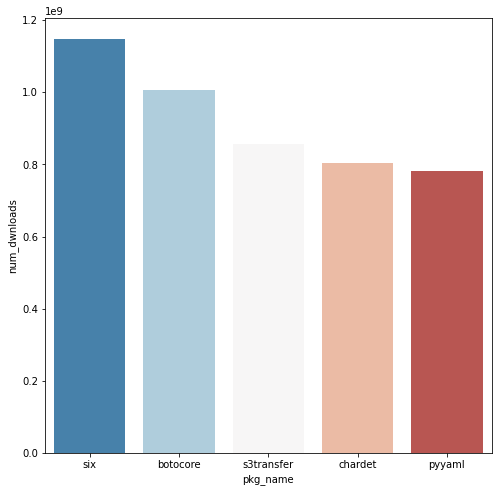

In [120]:
plt.figure(figsize=(8,8))
sns.barplot(data=metrics_df.sort_values(by='num_dwnloads',\
            ascending=False).head(5),x='pkg_name',y='num_dwnloads'\
            ,orient='v',palette='RdBu_r');
plt.savefig('top_5_dwn.png',bbox_inches='tight')

<AxesSubplot:>

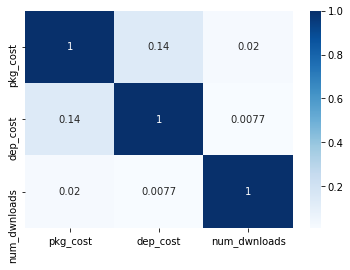

In [121]:
#explore the metrics correlation
sns.heatmap(metrics_df.drop(columns=['cum_percent']).corr(),annot=True,cmap='Blues')

In [122]:
#Run centrality measures on these packages
pkg_with_costs = metrics_df.name.to_list()

In [123]:
sub_dep_df = dep_df[dep_df.name.isin(pkg_with_costs)]

In [124]:
sub_dep_df = sub_dep_df[sub_dep_df.dependency_name!='none']

In [125]:
#create Graph as directed graph
G_sub = nx.from_pandas_edgelist(sub_dep_df, 'name', 'dependency_name',create_using=nx.DiGraph() )
print(nx.info(G_sub))

Name: 
Type: DiGraph
Number of nodes: 34266
Number of edges: 145044
Average in degree:   4.2329
Average out degree:   4.2329


## Run the centrality statistics on final dataframe with cost and downloads

In [126]:
# %%
#https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/

#using networkx package to determine degree centrality and saving in a dataframe
deg_centrality = nx.degree_centrality(G_sub)
s  = pd.Series(deg_centrality,index=deg_centrality.keys())
deg_centrality_df = pd.DataFrame(s)
deg_centrality_df = deg_centrality_df.reset_index()
deg_centrality_df.columns = ['node','deg_centrality']
deg_centrality_df = deg_centrality_df.set_index('node')

# Appending In/Out Degree Centrality to dataframe
in_deg_centrality = nx.in_degree_centrality(G_sub)
in_deg_centrality_s = pd.DataFrame(pd.Series(in_deg_centrality,index=in_deg_centrality.keys()))
deg_centrality_df['in_deg_centrality'] = in_deg_centrality_s
out_deg_centrality = nx.out_degree_centrality(G_sub)
out_deg_centrality_s = pd.DataFrame(pd.Series(out_deg_centrality,index=out_deg_centrality.keys()))
deg_centrality_df['out_deg_centrality'] = out_deg_centrality_s

# Appending Eigen Vector Centrality to the dataframe
# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html
# * Centrality for a node computed based on the centrality of its neighbors 
# * Nodes with higher values depend on fewer packages 
# * Eigenvector for node ⅈ is Ax=x where A is the adjacency matrix of graph G with eigenvalue 
# * Significant or influential nodes enable the development of the packages dependent on them reducing overall development costs and time to complete development. 

eigen_vec_centrality = nx.eigenvector_centrality(G_sub,max_iter=10000)
eigen_vec_centrality_s = pd.DataFrame(pd.Series(eigen_vec_centrality,index=eigen_vec_centrality.keys()))
deg_centrality_df['eigen_vec_centrality'] = eigen_vec_centrality_s
deg_centrality_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34266 entries, vcert to https.server
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   deg_centrality        34266 non-null  float64
 1   in_deg_centrality     34266 non-null  float64
 2   out_deg_centrality    34266 non-null  float64
 3   eigen_vec_centrality  34266 non-null  float64
dtypes: float64(4)
memory usage: 1.3+ MB


In [127]:
deg_centrality_df.sort_values(by='eigen_vec_centrality',ascending=False)

,deg_centrality,in_deg_centrality,out_deg_centrality,eigen_vec_centrality
node,,,,
six,0.076463,0.076463,0.000000,3.750591e-01
pytest,0.104509,0.104509,0.000000,3.371482e-01
setuptools,0.026850,0.026850,0.000000,3.038404e-01
twine,0.024135,0.023844,0.000292,2.356589e-01
wheel,0.022414,0.022414,0.000000,2.270094e-01
...,...,...,...,...
asphalt-templating,0.000292,0.000000,0.000292,6.854942e-34
ldapmgk,0.000175,0.000000,0.000175,6.854942e-34
cfnjsontoyaml,0.000058,0.000000,0.000058,6.854942e-34


In [128]:
deg_centrality_df = deg_centrality_df.reset_index()

In [129]:
#join new centrality measures with metrics of cost and downloads
metrics_cent_df = metrics_df.merge(deg_centrality_df,how='left',left_on='name',right_on='node')
metrics_cent_df.sample(10)

,name,pkg_cost,dep_cost,pkg_name,num_dwnloads,cum_percent,node,deg_centrality,in_deg_centrality,out_deg_centrality,eigen_vec_centrality
1868,django-timepiece,949964.93,0.00,django-timepiece,17158.0,98.698165,NaN,NaN,NaN,NaN,NaN
58529,vconfig,48340.35,4068767.59,vconfig,1200.0,99.927724,vconfig,0.000058,0.000000,0.000058,6.854942e-34
61477,mpilot,24390.76,1795765.72,mpilot,831.0,99.964516,mpilot,0.000175,0.000000,0.000175,6.854942e-34
36310,ipandoc,103616.48,0.00,ipandoc,1337.0,99.910266,NaN,NaN,NaN,NaN,NaN
13000,pysqlite3,246219.82,0.00,pysqlite3,235026.0,96.470416,pysqlite3,0.000058,0.000058,0.000000,6.786393e-32
31120,pyaavso,119433.87,0.00,pyaavso,5526.0,99.432610,pyaavso,0.000088,0.000000,0.000088,6.854942e-34
41820,zgitignore,89397.02,0.00,zgitignore,88873.0,97.411640,zgitignore,0.000029,0.000029,0.000000,3.427471e-32
57199,django-boolean-switch,52637.74,0.00,django-boolean-switch,8964.0,99.147765,NaN,NaN,NaN,NaN,NaN
5609,kconfiglib,462671.07,0.00,kconfiglib,211930.0,96.588997,kconfiglib,0.000088,0.000058,0.000029,6.786393e-32
56204,harser,55366.93,0.00,harser,4905.0,99.493146,harser,0.000058,0.000000,0.000058,6.854942e-34


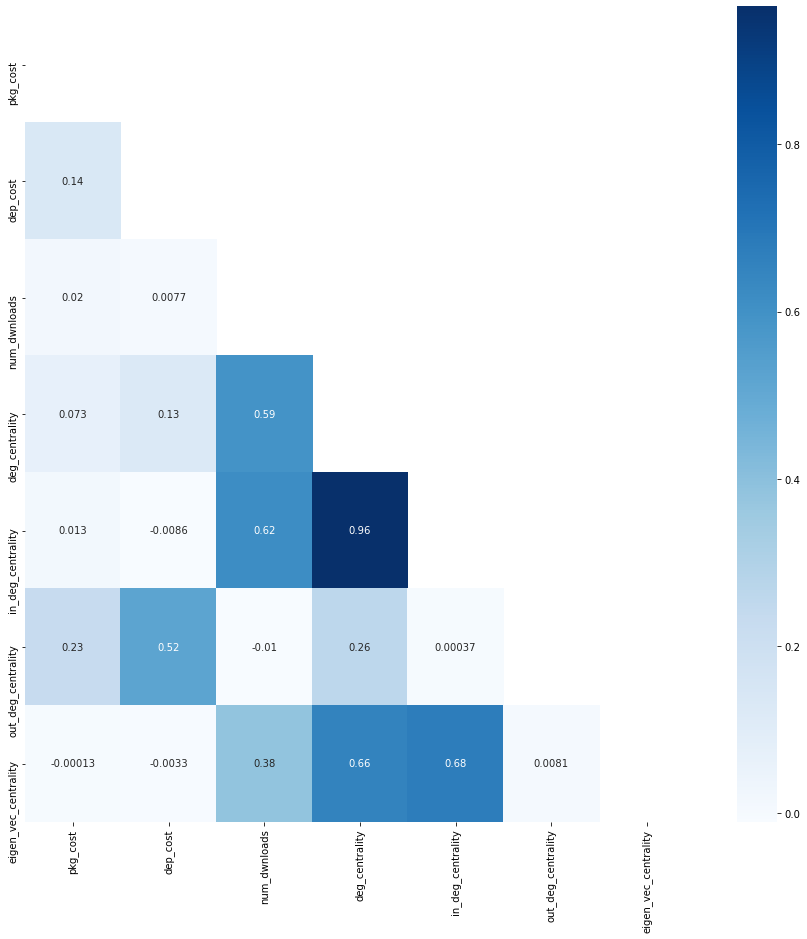

In [130]:
#explore the metrics correlation -
#check with Nick also and interpret this
plt.figure(figsize=(15,15))
matrix = np.triu(metrics_cent_df.drop(columns=['cum_percent']).corr())
sns.heatmap(metrics_cent_df.drop(columns=['cum_percent']).corr(),annot=True,cmap='Blues',mask=matrix)
plt.savefig('cent_corr_cost.png',bbox_inches='tight')

* In Degree and Degree: Directed graph and in-degree centrality represents how many packags depen upon the package. In our nw we have significant number of packages a high in-degree centrality. Based on the way degreew centrality is calculated, packages typically have a higher in-degree than out-degree and therefore the in-degree makes up larger portion fo the degree centrality. Therefore degree and in-degree are expressing the same thing.
* Deg centrality and reuse: reues ~ in-degree. Simialr to above.
* Deg Centrality - eigen: Degree captures number of vector and eigen captures number of connection and the weight based on neighbor conenctions. They are highly correlated because some of the packages which have high degree centrality may also be well conencted with neighbors which are highly connected. Eg: ----   but not perfectly correlated because though some have high degree centrality but the neighbors are not well connected to other packages.
* Reuse and downloads: When a package is downlaoded, it is forced to download the dependencies. Therefore when a package has high reuse count it might also be downlaoded the most. However, if the dependecy exists already on the environment it may not be always downloaded. 
* Downloads and eigen: Core component of your largest software suite
* Out degree and pkg cost: When a package is dependent on other packages, tit might seem liek they shoudl cost less. However, there are packages whic hrelay on other packages have somewhat large cost eg: ------

#### Relationship between num_downloads and other metrics

* In Degree and Degree: Directed graph and in-degree centrality represents how many packags depen upon the package. In our nw we have significant number of packages a high in-degree centrality. Based on the way degreew centrality is calculated, packages typically have a higher in-degree than out-degree and therefore the in-degree makes up larger portion fo the degree centrality. Therefore degree and in-degree are expressing the same thing.
* Deg centrality and reuse: reues ~ in-degree. Simialr to above.
* Deg Centrality - eigen: Degree captures number of vector and eigen captures number of connection and the weight based on neighbor conenctions. They are highly correlated because some of the packages which have high degree centrality may also be well conencted with neighbors which are highly connected. Eg: ----   but not perfectly correlated because though some have high degree centrality but the neighbors are not well connected to other packages.
* Reuse and downloads: When a package is downlaoded, it is forced to download the dependencies. Therefore when a package has high reuse count it might also be downlaoded the most. However, if the dependecy exists already on the environment it may not be always downloaded. 
* Downloads and eigen: Core component of your largest software suite
* Out degree and pkg cost: When a package is dependent on other packages, tit might seem liek they shoudl cost less. However, there are packages whic hrelay on other packages have somewhat large cost eg: ------